## Setup

### Import Required Packages

In [1]:
from graph_solver import *
from io_utils import graph_generator, graph_parser, file_writer, graph_visualizer
from IPython.display import Image

### Utility Functions

In [2]:
def vis_graph(g):
    img, ag = nx.nx_agraph.view_pygraphviz(g, prog="dot", show=False)
    display(Image(filename=img))
    

In [3]:
import tempfile


def viz_agraph(g):
    ext = "png"
    suffix = f".{ext}"
    path = tempfile.NamedTemporaryFile(suffix=suffix, delete=False)

    # Write graph to file
    g.draw(path=path, prog='dot')
    path.close()

    display(Image(filename=path.name))

## Generating the Dependency Graph

First, for each of the parts and each of the connections in the assembly model, a node is generated in `dependency_graph`. Each `part_node` is then connected to each `connection_node` that connects to it with a `connection_edge`. Next, the collisions between the parts and screws' extensions are detected, and for each one, a `collision_edge` connects the `connection_node` to the `part_node`.

In [4]:
ass_dep = nx.DiGraph()

ass_dep.add_nodes_from(range(9), TYPE="PART")
ass_dep.add_nodes_from("ABCDEFGHI", TYPE="CONN")

ass_dep.add_edges_from([
    (1, 'A'), (3, 'A'), (1, 'B'), (4, 'B'), (2, 'C'), (5, 'C'),
    (2, 'D'), (6, 'D'), (1, 'E'), (0, 'E'), (2, 'F'), (0, 'F'),
    (6, 'G'), (7, 'G'), (0, 'H'), (7, 'H'), (5, 'I'), (8, 'I'),
], TYPE="CONN", color='grey')

ass_dep.add_edges_from([
    ('A', 2), ('B', 2), ('C', 1), ('D', 1), ('G', 5), ('I', 6),
], TYPE="COLL", color='red')

`dependency_graph`:

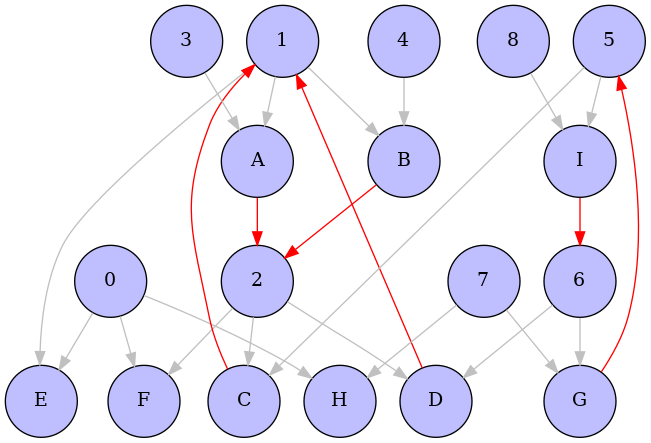

In [5]:
vis_graph(ass_dep)

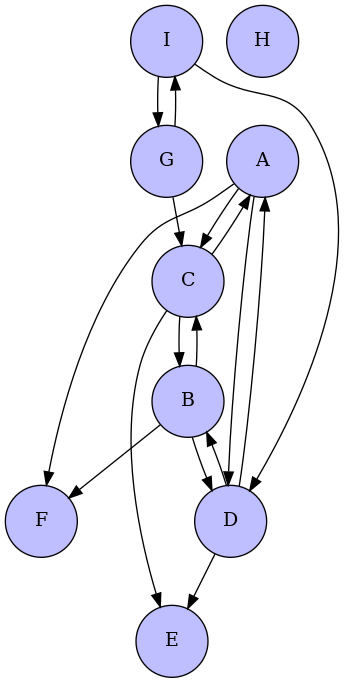

In [6]:
con_dep = convert_ass_dep_to_con_dep(ass_dep)
vis_graph(con_dep)

### Strongly Connected Components in the Graph

In [7]:
sccs = {f"cluster_{i}": {"nodes": scc, "sub_clusters": []} for i, scc in enumerate(nx.strongly_connected_components(ass_dep)) if len(scc) > 1}

In [10]:
esccs = {}
scc = list(sccs.keys())[0]
esccs[f"{scc}_ext"] = {"sub_clusters": {scc: sccs[scc]}}
esccs[f"{scc}_ext"]["nodes"] = set(extend_sub_graph_with_parts(ass_dep, sccs[scc]["nodes"]).nodes)
print(esccs[f"{scc}_ext"])

{'sub_clusters': {'cluster_4': {'nodes': {1, 2, 'A', 'C', 'D', 'B'}, 'sub_clusters': []}}, 'nodes': {1, 2, 3, 4, 5, 6, 'A', 'C', 'D', 'B'}}


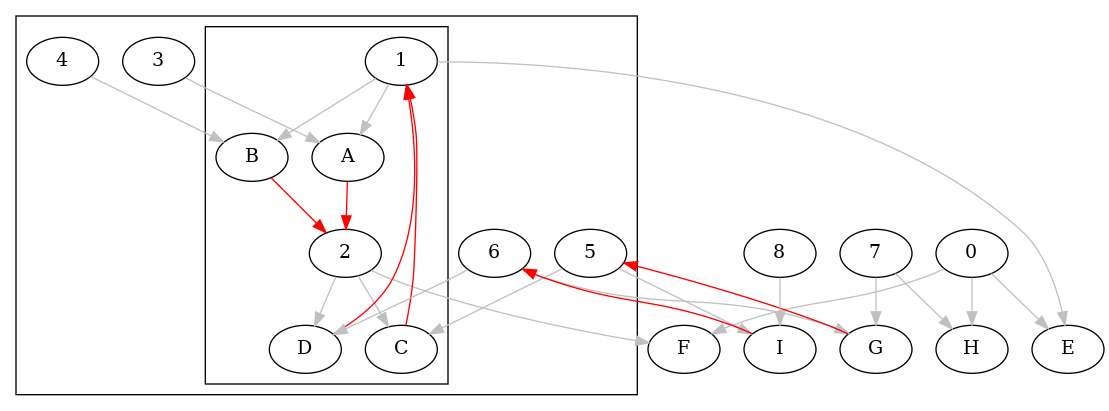

In [11]:
res = graph_generator.nx_to_agraph_with_subs(ass_dep, esccs)
viz_agraph(res)

	>> ADDING CLUSTER: CL > CLUSTER LEVEL: 0 > NODES: {1, 2, 3, 4, 5, 6, 'A', 'C', 'D', 'B'}


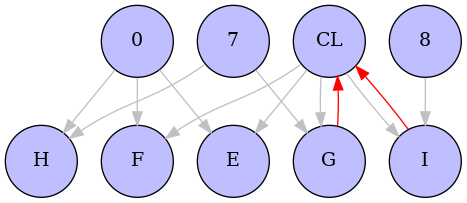

In [13]:
clustered = collapse_nodes(ass_dep, esccs[f"{scc}_ext"]["nodes"], "CL")
vis_graph(clustered)